## Import Modules

In [8]:
import os
from numpy.random import seed
seed(888)

import tensorflow as tf
tf.random.set_seed(404)
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset

In [3]:
def load_csv_from_zip(zip_path: str, filename: str, header=None, as_array: bool = True) -> pd.DataFrame:
    """
    Load a CSV file directly from a ZIP archive.

    Parameters
    ----------
    zip_path : str
        Path to the ZIP archive.
    filename : str
        Name of the CSV file inside the ZIP archive.
    header : int, list of int, or None, default None
        Row(s) to use as the column names. Use None to keep all rows as data.
    as_array : bool, default True
        If True, return as a NumPy array. If False, return as a DataFrame.

    Returns
    -------
    np.ndarray or pd.DataFrame
        Data in array or DataFrame format.
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(filename) as f:
            df = pd.read_csv(f, header=header)
    return df.values if as_array else df

ZIP_PATH = "data/MNIST.zip"

x_train_all = load_csv_from_zip(ZIP_PATH, "digit_xtrain.csv")
x_test = load_csv_from_zip(ZIP_PATH, "digit_xtest.csv")
y_train_all = load_csv_from_zip(ZIP_PATH, "digit_ytrain.csv")
y_test = load_csv_from_zip(ZIP_PATH, "digit_ytest.csv")

## EDA

x_train shape: (60000, 784)
y_train shape: (60000, 1)
x_test shape: (10000, 784)
y_test shape: (10000, 1)


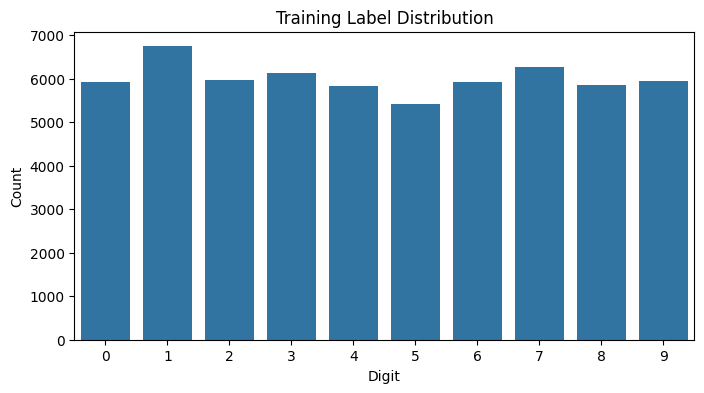

Missing values in x_train: 0
Missing values in y_train: 0
Missing values in x_test: 0
Missing values in y_test: 0
Pixel range in x_train: 0 to 255
Pixel range in x_test: 0 to 255


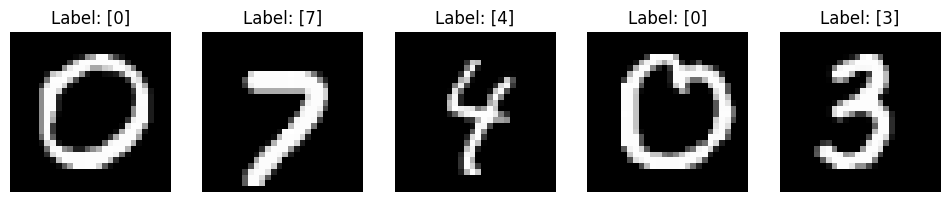

Train mean pixel value: 33.318421449829934
Train std pixel value: 78.56748998339742
Test mean pixel value: 33.791224489795916
Test std pixel value: 79.1724632222863


In [4]:
def eda_mnist(x_train, y_train, x_test, y_test, sample_size=5):
    # 1. Check shapes
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    # 2. Check label distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y_train.flatten())
    plt.title("Training Label Distribution")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

    # 3. Check missing values
    print("Missing values in x_train:", np.isnan(x_train).sum())
    print("Missing values in y_train:", np.isnan(y_train).sum())
    print("Missing values in x_test:", np.isnan(x_test).sum())
    print("Missing values in y_test:", np.isnan(y_test).sum())

    # 4. Check pixel value ranges
    print("Pixel range in x_train:", x_train.min(), "to", x_train.max())
    print("Pixel range in x_test:", x_test.min(), "to", x_test.max())

    # 5. Show random samples
    plt.figure(figsize=(12, 3))
    indices = np.random.choice(len(x_train), sample_size, replace=False)
    for i, idx in enumerate(indices):
        img = x_train[idx].reshape(28, 28)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {y_train[idx]}")
    plt.show()

    # 6. Basic statistics
    print("Train mean pixel value:", np.mean(x_train))
    print("Train std pixel value:", np.std(x_train))
    print("Test mean pixel value:", np.mean(x_test))
    print("Test std pixel value:", np.std(x_test))

eda_mnist(x_train_all, y_train_all, x_test, y_test)

## Data Pre-processing

### Re-scale

In [5]:
# Re-scale data between 0 - 1
x_train_all, x_test = x_train_all/255.0 , x_test / 255.0

### Convert target values to one-hot encoding

In [6]:
NUM_CLASSES = 10

y_train_all = np.eye(NUM_CLASSES)[y_train_all.ravel()]
y_test = np.eye(NUM_CLASSES)[y_test.ravel()]

### Create Validation set from training data

In [7]:
VALIDATION_SIZE = 10000

x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

## MLP Model Training

In [24]:
# --- One-hot setup (labels are already (N, 10) in the previous step) ---
# Note: We need to perform one-hot encoding before training
NUM_CLASSES = 10  # fixed for MNIST
LR = 1e-3
EPOCHS = 50
BATCH_SIZE = 128

NUM_LAYER_1 = 512
NUM_LAYER_2 = 64

# -------- Loss & metrics for ONE-HOT labels --------
loss_obj  = keras.losses.CategoricalCrossentropy()
train_acc = keras.metrics.CategoricalAccuracy(name="train_acc")
val_acc   = keras.metrics.CategoricalAccuracy(name="val_acc")

In [25]:
# -------- Build an MLP (Flattened input) --------
model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),  # e.g., 784
    layers.Dense(
        NUM_LAYER_1, activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="dense_512"
    ),
    layers.Dropout(0.2, name="dropout_0_2"),  # keep 80% of output
    layers.Dense(
        NUM_LAYER_2, activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="dense_64"
    ),
    layers.Dense(
        NUM_CLASSES, activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="classifier"
    ),
], name="mnist_mlp_onehot")

optimizer = keras.optimizers.Adam(LR)

# -------- tf.data pipelines --------
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val,   y_val)).batch(BATCH_SIZE)

# -------- TensorBoard writers (optional) --------
train_writer = tf.summary.create_file_writer("logs/custom/train")
val_writer   = tf.summary.create_file_writer("logs/custom/val")

# -------- One training step --------
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)  # enable dropout
        loss   = loss_obj(y, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc.update_state(y, y_pred)
    return loss

# -------- One validation step --------
@tf.function
def val_step(x, y):
    y_pred = model(x, training=False)  # disable dropout
    v_loss = loss_obj(y, y_pred)
    val_acc.update_state(y, y_pred)
    return v_loss

In [26]:
# -------- Training loop --------
train_losses, val_losses = [], []
train_accs, val_accs     = [], []

for epoch in range(EPOCHS):
    # --- train ---
    train_acc.reset_state()
    epoch_train_loss = 0.0
    batches = 0
    for xb, yb in train_ds:
        loss = train_step(xb, yb)
        epoch_train_loss += loss
        batches += 1
    epoch_train_loss = epoch_train_loss / tf.cast(batches, tf.float32)

    # --- validate ---
    val_acc.reset_state()
    epoch_val_loss = 0.0
    vbatches = 0
    for xb, yb in val_ds:
        vloss = val_step(xb, yb)
        epoch_val_loss += vloss
        vbatches += 1
    epoch_val_loss = epoch_val_loss / tf.cast(vbatches, tf.float32)

    # --- TensorBoard (optional) ---
    with train_writer.as_default():
        tf.summary.scalar("loss", epoch_train_loss, step=epoch)
        tf.summary.scalar("accuracy", train_acc.result(), step=epoch)
    with val_writer.as_default():
        tf.summary.scalar("loss", epoch_val_loss, step=epoch)
        tf.summary.scalar("accuracy", val_acc.result(), step=epoch)

    # --- log & collect history ---
    print(f"Epoch {epoch:02d} | "
          f"Train Loss {epoch_train_loss:.4f} Acc {train_acc.result():.4f} | "
          f"Val Loss {epoch_val_loss:.4f} Acc {val_acc.result():.4f}")

    train_losses.append(float(epoch_train_loss))
    val_losses.append(float(epoch_val_loss))
    train_accs.append(float(train_acc.result()))
    val_accs.append(float(val_acc.result()))

print("Done training!")

Epoch 00 | Train Loss 0.3257 Acc 0.9033 | Val Loss 0.1476 Acc 0.9553
Epoch 01 | Train Loss 0.1275 Acc 0.9621 | Val Loss 0.1030 Acc 0.9704
Epoch 02 | Train Loss 0.0872 Acc 0.9731 | Val Loss 0.0938 Acc 0.9711
Epoch 03 | Train Loss 0.0658 Acc 0.9797 | Val Loss 0.0824 Acc 0.9749
Epoch 04 | Train Loss 0.0511 Acc 0.9842 | Val Loss 0.0736 Acc 0.9785
Epoch 05 | Train Loss 0.0400 Acc 0.9867 | Val Loss 0.0740 Acc 0.9778
Epoch 06 | Train Loss 0.0322 Acc 0.9894 | Val Loss 0.0756 Acc 0.9781
Epoch 07 | Train Loss 0.0279 Acc 0.9910 | Val Loss 0.0687 Acc 0.9797
Epoch 08 | Train Loss 0.0244 Acc 0.9921 | Val Loss 0.0713 Acc 0.9802
Epoch 09 | Train Loss 0.0206 Acc 0.9934 | Val Loss 0.0731 Acc 0.9804
Epoch 10 | Train Loss 0.0176 Acc 0.9939 | Val Loss 0.0810 Acc 0.9797
Epoch 11 | Train Loss 0.0177 Acc 0.9939 | Val Loss 0.0809 Acc 0.9794
Epoch 12 | Train Loss 0.0169 Acc 0.9939 | Val Loss 0.0777 Acc 0.9811


2025-09-06 09:02:30.971661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13 | Train Loss 0.0165 Acc 0.9944 | Val Loss 0.0794 Acc 0.9809
Epoch 14 | Train Loss 0.0136 Acc 0.9954 | Val Loss 0.0877 Acc 0.9810
Epoch 15 | Train Loss 0.0130 Acc 0.9958 | Val Loss 0.0896 Acc 0.9813
Epoch 16 | Train Loss 0.0131 Acc 0.9954 | Val Loss 0.0848 Acc 0.9819
Epoch 17 | Train Loss 0.0120 Acc 0.9959 | Val Loss 0.0878 Acc 0.9810
Epoch 18 | Train Loss 0.0137 Acc 0.9950 | Val Loss 0.0887 Acc 0.9813
Epoch 19 | Train Loss 0.0115 Acc 0.9960 | Val Loss 0.0941 Acc 0.9810
Epoch 20 | Train Loss 0.0099 Acc 0.9969 | Val Loss 0.0991 Acc 0.9808
Epoch 21 | Train Loss 0.0116 Acc 0.9961 | Val Loss 0.1004 Acc 0.9791
Epoch 22 | Train Loss 0.0110 Acc 0.9960 | Val Loss 0.0936 Acc 0.9810
Epoch 23 | Train Loss 0.0083 Acc 0.9974 | Val Loss 0.0917 Acc 0.9821
Epoch 24 | Train Loss 0.0093 Acc 0.9969 | Val Loss 0.1105 Acc 0.9786
Epoch 25 | Train Loss 0.0111 Acc 0.9965 | Val Loss 0.1017 Acc 0.9793
Epoch 26 | Train Loss 0.0080 Acc 0.9972 | Val Loss 0.0856 Acc 0.9836
Epoch 27 | Train Loss 0.0085 Acc 0

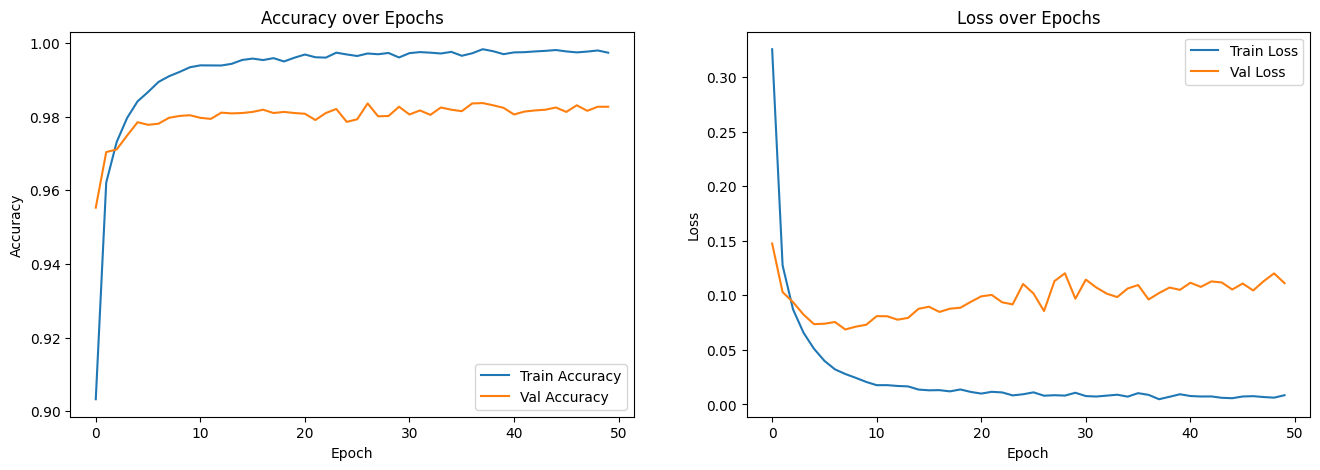

In [27]:
# -------- Plot curves --------
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over Epochs"); plt.legend()
plt.show()

## Make a Prediction

In [11]:
from PIL import Image

zip_path = "data/MNIST.zip"

with zipfile.ZipFile(zip_path) as z:
    with z.open("test_img.png") as f:
        img = Image.open(f)
        img = img.convert("L")   

img

In [12]:
img_array = np.array(img)

# 2. Invert colors if your training data is white text on black background
img_array = np.invert(img_array)

# 3. Normalize like training data (0–1)
img_array = img_array.astype("float32") / 255.0

# 4. Reshape to match model input
test_img = img_array.reshape(1, 28*28) 

# 5. Predict
probs = model.predict(test_img)  # shape (1, 10)
pred = np.argmax(probs, axis=1)

print(f"Prediction for test image is {pred[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for test image is 2


## Testing and Evaluation

Test accuracy: 0.9818 | Test loss: 0.1266


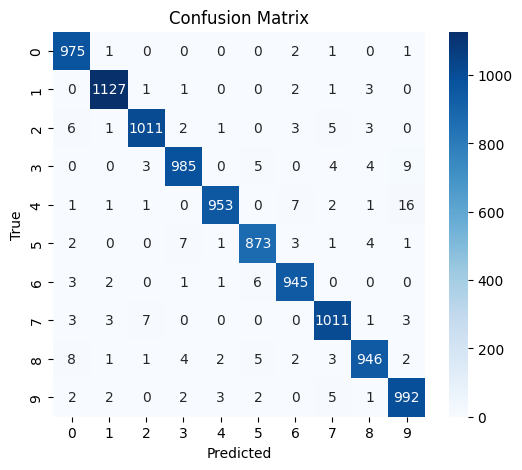

              precision    recall  f1-score   support

           0     0.9750    0.9949    0.9848       980
           1     0.9903    0.9930    0.9916      1135
           2     0.9873    0.9797    0.9835      1032
           3     0.9830    0.9752    0.9791      1010
           4     0.9917    0.9705    0.9810       982
           5     0.9798    0.9787    0.9792       892
           6     0.9803    0.9864    0.9834       958
           7     0.9787    0.9835    0.9811      1028
           8     0.9823    0.9713    0.9768       974
           9     0.9688    0.9832    0.9759      1009

    accuracy                         0.9818     10000
   macro avg     0.9817    0.9816    0.9816     10000
weighted avg     0.9819    0.9818    0.9818     10000



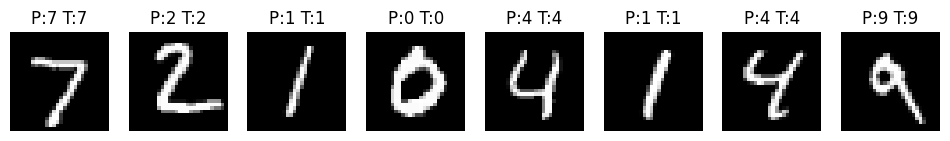

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1) compile for evaluation (pick the correct loss by your label format)
is_one_hot = (y_train.ndim == 2 and y_train.shape[1] > 1)
loss_name  = "categorical_crossentropy" if is_one_hot else "sparse_categorical_crossentropy"

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=loss_name,
              metrics=["accuracy"])

# 2) evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# 3) predictions
probs = model.predict(x_test, verbose=0)         # (N, num_classes)
preds = probs.argmax(axis=1)
true  = y_test.argmax(axis=1) if is_one_hot else y_test.reshape(-1)

# 4) confusion matrix & report
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

print(classification_report(true, preds, digits=4))

# 5) visualize a few predictions
plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    plt.title(f"P:{preds[i]} T:{true[i]}")
plt.show()
